In [8]:
import import_ipynb
%run localisation.ipynb
%run local_navigation_final.ipynb

# Global navigation functions
those function are only temporary and used to test the well functioning of the state machine

In [9]:
def get_angle_goal_thymio(tm_pos,tm_orient, goal_pos):
    """
    This function computes the angle between the direction the Thymio should point and the orientation of the robot 
    in order to be aligned with the goal
    
    Arguments: th_pos:    position of the Thymio 
               th_orient: orientation of the robot
               goal_pos:  [X,y] coordinates of the goal
               
    Return   : computed angle in range [-pi;pi]
    """
    
    #we start by computing the direction of the vector connecting the pose of the robot and the goal
    alpha = math.atan2(goal_pos[1]-tm_pos[1], goal_pos[0]-tm_pos[0])
    if alpha < 0:
        alpha += 2*math.pi
    
    theta = tm_orient-alpha
    
    if theta > math.pi:
        theta -= 2*math.pi
    if theta < -math.pi:
        theta += 2*math.pi

    return theta

In [10]:
angle_I_error = 0
def angle_PI(tm_pos, tm_orient, goal_pos, reset):
    """
        This function calulates the PI term related to the orientation of the robot to orient the robot to face the goal
    
    Arguments: Arguments: th_pos:    position of the Thymio 
               th_orient: orientation of the robot
               goal_pos:  [X,y] coordinates of the goal
               reset   : bool True if we want to reset the Integral error sum
    
    Return   : Speed increment to add/substract to the motors
    """
    #precision factor by which we first multiply the errors to gain in precision as the speed has to be an integer 
    #and truncation may affect the results
    PRECISION_FACTOR = 100
    max_error_sum = 1
    min_dist_to_goal = 10 #if we are next to the goal of 1 cm we do not update as we consider we are on the goal
    
    #we want to saturate the speed so we have a trapezoidal speed profile for smoothness of movement
    max_speed = 80
    Kp = 80
    Ki = 5
    
    global angle_I_error
    
    if reset:
        angle_I_error = 0
    
    #checking if we are on the gaol pos
    dist = math.sqrt((tm_pos[0]-goal_pos[0])**2+(tm_pos[1]-goal_pos[1])**2)
    
    if dist < min_dist_to_goal:
        return 0
    
    error = get_angle_goal_thymio(tm_pos, tm_orient, goal_pos)
    #print("error")
    #print(error)
    angle_I_error += error
    
     #antireset windup
    if angle_I_error > max_error_sum:
        angle_I_error = max_error_sum
        
    if angle_I_error < -max_error_sum:
        angle_I_error = -max_error_sum
    
    #print("int error")
    #print(angle_I_error)
    
    speed_angle = int(((Kp*error+Ki*angle_I_error)))
    #print("speed_angle")
    #print(speed_angle)
    
    if speed_angle > max_speed:
        speed_angle = max_speed
    if speed_angle < -max_speed:
        speed_amgle = -max_speed
    
    return speed_angle

In [11]:
dist_error_sum = 0
def distance_PI(tm_pos, tm_orient, goal_pos, reset):
    """
      This function returns the speed associated to the displacement of the robot so that it reaches the goal position
        
    
    Arguments: Arguments: th_pos:    position of the Thymio 
               th_orient: orientation of the robot
               goal_pos:  [X,y] coordinates of the goal
               reset   : bool True if we want to reset the Integral error sum
    
    Return   : Speed increment add to both motors
    """
    Max_dist_error = 20
    SCALING_FACTOR = 10
    max_speed = 150 #doesn't allow a speed larger than this value so that the dynamic is homogenous (speed doesn't linearly
                    #decrease until we are close to the goal)
    
    min_dist_to_goal = 0 #if we are next to the goal of 1 cm we do not update as we consider we are on the goal
    
    global dist_error_sum
    
    if reset:
        dist_error_sum = 0
        
    dispacement_speed = 0
    Kp = 20
    Ki = 4
    
    #compute the distance
    
    dist = math.sqrt((tm_pos[0]-goal_pos[0])**2+(tm_pos[1]-goal_pos[1])**2)
    if dist <  min_dist_to_goal:
        dist = 0
    
    #if the Thymio orientation is too far from facing the goal, we first reorient the robot until it faces the goal => 
    #no displacement speed
    Phi = get_angle_goal_thymio(tm_pos,tm_orient, goal_pos)
    if Phi> math.pi/2 or Phi <-math.pi/2:
        displacement_speed = 0
    else:
        dist_error_sum += dist
        
        #antireset windup
        if dist_error_sum > Max_dist_error:
            dist_error_sum = Max_dist_error
        if dist_error_sum < -Max_dist_error:
            dist_error_sum = -Max_dist_error
        
        displacement_speed = int((dist*Kp+Ki*dist_error_sum)//SCALING_FACTOR)
        
        #saturates the speed if needed
        if displacement_speed > max_speed:
            displacement_speed = max_speed
        if displacement_speed < -max_speed:
            displacement_speed = -max_speed
    
    return displacement_speed
    

# Main
This is the core part of the code calling all the apropriate functions

In [12]:
import tdmclient.notebook
await tdmclient.notebook.start()

GLOBAL
Go_left
False
LOCAL
GLOBAL


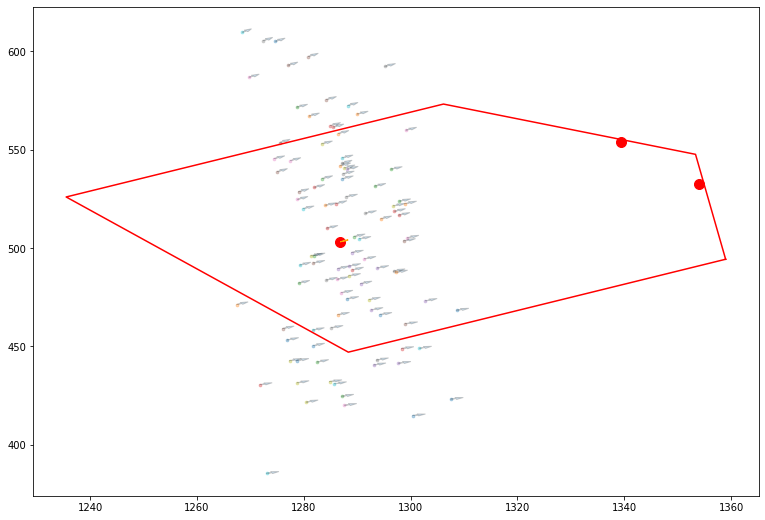

In [17]:
#putting everything together
#putting together functions
obstacle = False
ITER_PATH_FREE = 9 #number of iteration where the path to the goal is free before we stop following the obstacle
dist_thresh = 20
#States of the robot
STATE_GLOBAL_NAV = 0
STATE_LOCAL_NAV = 1

#Threshold for obstacle detection
THRESHOLD_PROX1 = 1700
THRESHOLD_PROX2 = 1500
THRESHOLD_PROX3 = 1500
THRESHOLD_PROX0 = 2000
THRESHOLD_PROX4 = 2000

#refresh period
dt = 0.3

#initliasie the pose of the robot
pose = Pose(500,500,0)
pose.set_coords(500, 500, 0.00)

robot_state = STATE_GLOBAL_NAV

#objective
goal = [1300, 500]
coords = pose.get_coords()
dist_to_goal = math.sqrt((coords['x']-goal[0])**2+(coords['y']-goal[1])**2)

#initialize variable for the loop
go_left = True
reset_glob_regulator = True
reset_local_regulator = True
speeds_robot = [0, 0]
obstacle = False

#counters used to determine if we must reset the PID controllers (integrator terms and derivatives)
local_nav_iter = 1
global_nav_iter = 1
#for local navigation counts how many consecutive iteration the path is free (used to go back to global nav)
free_path_iter = 0 
while dist_to_goal > 20:
    
    
    if robot_state == STATE_GLOBAL_NAV:
        
        
        if global_nav_iter > 1:
            reset_glob_regulator = False
        else:
            print("GLOBAL")
            leds_circle[3] = 25
            leds_circle[1] = 0

        global_nav_iter += 1
        
        prox = prox_horizontal
    
        obstacle = obstacle or obstacle_detected(prox[2], THRESHOLD_PROX2)
        obstacle = obstacle or obstacle_detected(prox[1], THRESHOLD_PROX1)
        obstacle = obstacle or obstacle_detected(prox[3], THRESHOLD_PROX3)
        obstacle = obstacle or obstacle_detected(prox[0], THRESHOLD_PROX0)
        obstacle = obstacle or obstacle_detected(prox[4], THRESHOLD_PROX4)
        
        speed_theta = angle_PI([coords['x'],coords['y']], coords['theta'], goal, reset_glob_regulator)
        speed_disp = distance_PI([coords['x'],coords['y']], coords['theta'], goal, reset_glob_regulator)
        
        speeds_robot = [speed_disp+speed_theta, speed_disp-speed_theta]
        
        if obstacle:
            robot_state = STATE_LOCAL_NAV
            coords = pose.get_coords()
            Go_left = choose_direction(prox, goal, (coords['x'],coords['y']), coords['theta'])
            print("Go_left")
            print(Go_left)
            reset_local_regulator = True
            local_nav_iter = 1
            free_path_iter = 0
            
            
    elif robot_state == STATE_LOCAL_NAV:
        
        prox = prox_horizontal
        
        if local_nav_iter > 1:
            reset_local_regulator = False
        else:
            print("LOCAL")
            leds_circle[3] = 0
            leds_circle[1] = 25

            
        local_nav_iter += 1
        
        if Go_left:
        #if turn left obstacle is on the rigth
            speeds = right_obst_follow(reset_local_regulator)
            speeds_robot = [speeds[1], speeds[0]]
        
        
        else:
            speeds = left_obst_follow(reset_local_regulator)
            speeds_robot = [speeds[1], speeds[0]]
    
  
        coords = pose.get_coords()
    
        if path_to_goal_free(coords['theta'], (coords['x'],coords['y']), goal ,prox):
            free_path_iter += 1
            if free_path_iter > ITER_PATH_FREE:
                    robot_state = STATE_GLOBAL_NAV
                    global_nav_iter = 1
                    reset_glob_regulator = True
                    obstacle = False
                    
                    
        else:
            free_path_iter = 0
        
    
    motor_left_target = speeds_robot[0]
    motor_right_target = speeds_robot[1]
    prox_grnd = prox_ground_delta
    speeds_meas = [motor_left_speed,motor_right_speed]
    sleep(dt)
    pose.update(speed=speeds_meas, prox=prox_grnd, dt=dt, myMap = myMap)
    coords = pose.get_coords()
    dist_to_goal = math.sqrt((coords['x']-goal[0])**2+(coords['y']-goal[1])**2)
        

sleep(dt)
motor_left_target = 0
motor_right_target = 0
pose.plot()


In [14]:
motor_left_target = 0

In [15]:
motor_right_target = 0